In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from datetime import datetime

Leggiamo i dati da results e prendiamo tutti i valori tranne quelli dei mondiali dal 1993, questo per andare poi ad allenare l'algoritmo e avere i dati per predirre tutti i mondiali (dal 1994 al 2018)

In [2]:
games = pd.read_csv('results.csv')
games['date'] = pd.to_datetime(games['date'], format = '%Y-%m-%d')
worldCup2018 = games.query("tournament == 'FIFA World Cup' and date >= '2018-01-01' and date < '2019-01-01'").sort_values(by = "date")
games.query("not (date >= '1993-01-01' and tournament == 'FIFA World Cup')", inplace = True)
games.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Leggiamo i rank ed aggiustiamo i nomi delle squadre

In [3]:
fifaWorldRanking = pd.read_csv('fifa_ranking.csv')

fifaWorldRanking['rank_date'] = pd.to_datetime(fifaWorldRanking['rank_date'], format = '%Y-%m-%d')
fifaWorldRanking.head()

#missing teams fix
fifaWorldRanking['country_full'].replace({
  'IR Iran': 'Iran',
  'Serbia and Montenegro': 'Serbia',
  'Côte d\'Ivoire': 'Ivory Coast',
  'Korea DPR': 'North Korea',
  'USA': 'United States',
  'Korea Republic': 'South Korea'
}, inplace = True)

fifaWorldRanking.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


Leggiamo i match dei mondiali considerando solo quelli dal 1994. 

Cambiamo il nome alle colonne per semplificare l'accesso e sistemiamo i nomi delle squadre nelle condizioni di vittoria (casi di pareggio) e le date

In [4]:
worldCupMatches = pd.read_csv('WorldCupMatches.csv').query("Year >= 1994")
worldCupMatches = worldCupMatches[['Year', 'Datetime', 'Stage', 'Home Team Name', 'Home Team Goals', 'Away Team Goals', 'Away Team Name', 'Win conditions']]
worldCupMatches.columns = ['Year', 'Datetime', 'Stage', 'HomeTeamName', 'HomeTeamGoals', 'AwayTeamGoals', 'AwayTeamName', 'WinConditions']

worldCupMatches.WinConditions.replace({
  'rn">Republic of Ireland': 'Republic of Ireland',
  'rn">Bosnia and Herzegovina': 'Bosnia and Herzegovina',
  'rn">Trinidad and Tobago': 'Trinidad and Tobago',
  'rn">Serbia and Montenegro': 'Serbia',
  'IR Iran': 'Iran',
  'Serbia and Montenegro': 'Serbia',    
  'Côte d\'Ivoire': 'Ivory Coast',
  'C�te d\'Ivoire': 'Ivory Coast',
  'Korea DPR': 'North Korea',
  'USA': 'United States',
  'Korea Republic': 'South Korea'
}, regex = True, inplace = True)

worldCupMatches.Datetime.replace({
  'June': '06',
  'Jun': '06',
  'July':'07',
  'Jul': '07',
  'May': '05'
}, regex = True, inplace = True)

Sistemiamo i nomi delle squadre e correggiamo i nomi delle fasi

In [5]:
worldCupMatches['Datetime'] = pd.to_datetime(worldCupMatches['Datetime'], format = "%d %m %Y - %H:%M ")

worldCupMatches['AwayTeamName'].replace({
    'rn">Republic of Ireland': 'Republic of Ireland',
    'rn">Bosnia and Herzegovina': 'Bosnia and Herzegovina',
    'rn">Trinidad and Tobago': 'Trinidad and Tobago',
    'rn">Serbia and Montenegro': 'Serbia',
    'IR Iran': 'Iran',
    'Serbia and Montenegro': 'Serbia',    
    'Côte d\'Ivoire': 'Ivory Coast',
    'C�te d\'Ivoire': 'Ivory Coast',
    'Korea DPR': 'North Korea',
    'USA': 'United States',
    'Korea Republic': 'South Korea'   
}, inplace = True)

worldCupMatches['HomeTeamName'].replace({    
  'rn">Republic of Ireland': 'Republic of Ireland',
  'rn">Bosnia and Herzegovina': 'Bosnia and Herzegovina',
  'rn">Trinidad and Tobago': 'Trinidad and Tobago',
  'rn">Serbia and Montenegro': 'Serbia',
  'IR Iran': 'Iran',
  'Serbia and Montenegro': 'Serbia',    
  'Côte d\'Ivoire': 'Ivory Coast',
  'Korea DPR': 'North Korea',
  'USA': 'United States',
  'Korea Republic': 'South Korea',
  'C�te d\'Ivoire': 'Ivory Coast'
}, inplace = True)

worldCupMatches['Stage'].replace({
  'Match for third place': 'Third place',
  'Play-off for third place': 'Third place'
}, inplace = True)

worldCupMatches.drop_duplicates(inplace = True)
worldCupMatches.head()

,Year,Datetime,Stage,HomeTeamName,HomeTeamGoals,AwayTeamGoals,AwayTeamName,WinConditions
464,1994.0,1994-06-17 19:30:00,Group C,Spain,2.0,2.0,South Korea,
465,1994.0,1994-06-17 15:00:00,Group C,Germany,1.0,0.0,Bolivia,
466,1994.0,1994-06-18 11:30:00,Group A,United States,1.0,1.0,Switzerland,
467,1994.0,1994-06-18 16:00:00,Group E,Italy,0.0,1.0,Republic of Ireland,
468,1994.0,1994-06-18 19:30:00,Group A,Colombia,1.0,3.0,Romania,


Eseguito filtro su solamente partite dei mondiali andando a recuperare i partecipanti ai mondiali

In [6]:
world_cup_games = games.query("tournament == 'FIFA World Cup'")
world_cup_teams = pd.concat([world_cup_games['home_team'], world_cup_games['away_team']]).unique()
print(world_cup_teams)

['Belgium' 'France' 'Brazil' 'Peru' 'Argentina' 'Chile' 'Bolivia'
 'Paraguay' 'Uruguay' 'Austria' 'Czechoslovakia' 'Egypt' 'Italy'
 'Netherlands' 'Germany' 'Cuba' 'Hungary' 'Spain' 'Switzerland' 'Mexico'
 'England' 'Sweden' 'Scotland' 'South Korea' 'Colombia' 'Russia'
 'Bulgaria' 'North Korea' 'Portugal' 'Israel' 'Morocco' 'El Salvador'
 'DR Congo' 'German DR' 'Poland' 'Yugoslavia' 'Haiti' 'Australia' 'Iran'
 'Algeria' 'Honduras' 'Canada' 'Northern Ireland' 'Denmark' 'Iraq'
 'United Arab Emirates' 'United States' 'Costa Rica' 'Cameroon'
 'Republic of Ireland' 'Romania' 'Indonesia' 'Norway' 'Turkey' 'Wales'
 'Tunisia' 'New Zealand' 'Kuwait']


Di seguito si recuperano i rank delle squadre sopra, quindi i rank dei team che effettivamente hanno partecipato ai mondiali.

In [7]:
fifaWorldRanking = fifaWorldRanking[fifaWorldRanking['country_full'].isin(world_cup_teams)]
fifaWorldRanking.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


Recuperiamo le partite giocate dalle squadre che hanno partecipato ai mondiali

In [8]:
df_teams_home = games[games['home_team'].isin(world_cup_teams)]
df_teams_away = games[games['away_team'].isin(world_cup_teams)]
df_teams = pd.concat((df_teams_home, df_teams_away))
df_teams.drop_duplicates(inplace = True)
df_teams.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Vado a calcolare tutti i risultati delle partite per allenare il modello. Nel caso non ci siano risultati di ranking, mettiamo -1 alla squadra di casa per renderla "favorita".

Ricordiamo che più un rank è basso e più la squadra è favorita sulla carta.

Alla fine memorizziamo l'esito (winner).

In [9]:
def getNormalizedRow(fifaRanking, homeTeam, awayTeam, homeScore = None, awayScore = None):
  if fifaRanking is None:
    home_ranking = -1
    away_ranking = 5000
  else:
    home_ranking = fifaRanking[fifaRanking['country_full'] == homeTeam].tail(1)
    home_ranking = home_ranking['rank'].iloc[0] if len(home_ranking) > 0 else -1

    away_ranking = fifaRanking[fifaRanking['country_full'] == awayTeam].tail(1)
    away_ranking = away_ranking['rank'].iloc[0] if len(away_ranking) > 0 else 5000
  
  if home_ranking < away_ranking: 
    row = {'favorite': homeTeam, 'sfavorite': awayTeam}   
  else:
    row = {'favorite': awayTeam,'sfavorite': homeTeam}  

  #Divido il caso Training dal caso di predizione
  if homeScore is None or awayScore is None:     
    return row

  if home_ranking < away_ranking:
    diff_goal = homeScore - awayScore
  else:
    diff_goal = awayScore - homeScore
  
  #etichetta che associamo al risultato
  result = 1 #Draw 
  if diff_goal > 0:
    result = 2 #favourite won
  elif diff_goal < 0:
    result = 0 #favourite lost 
    
  row['winner'] = result
  return row

Per ogni partita mi recupero i rank delle squadre per quella data (circa) e calcolo il risultato della favorita (getNormalizedRow). 

I risultati sono quelli utiilizzati per allenare l'algoritmo

In [10]:
filteredData = []
firstFifaRankingDate =  min(fifaWorldRanking['rank_date'])

for key, value in games.iterrows():  
  date = value['date']
  homeTeam = value['home_team']
  awayTeam = value['away_team']
  
  #recuperiamo il rank dei team in base alla data della partita
  if date >= firstFifaRankingDate:
    fifaRankingBeforeDate = fifaWorldRanking[(fifaWorldRanking.rank_date <= date) & (fifaWorldRanking.country_full.isin([homeTeam,awayTeam]))]
  else:
    fifaRankingBeforeDate = None
    
  row = getNormalizedRow(fifaRankingBeforeDate,homeTeam,awayTeam,value['home_score'], value['away_score'])
  filteredData.append(row)

dataToAnalyze = pd.DataFrame(filteredData)
dataToAnalyze.head()

,favorite,sfavorite,winner
0,Scotland,England,1
1,England,Scotland,2
2,Scotland,England,2
3,England,Scotland,1
4,Scotland,England,2


In [11]:
final = pd.get_dummies(dataToAnalyze, prefix = ['favorite', 'sfavorite'], columns = ['favorite', 'sfavorite'])

# Separo risultati da dati iniziali
X = final.drop(['winner'], axis = 1)
y = final["winner"]
y = y.astype('int')

# Divido in due i dati per avere dati di training e di confronto
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
final.head()

,winner,favorite_Abkhazia,favorite_Afghanistan,favorite_Albania,favorite_Alderney,favorite_Algeria,favorite_American Samoa,favorite_Andalusia,favorite_Andorra,favorite_Angola,favorite_Anguilla,favorite_Antigua and Barbuda,favorite_Arameans Suryoye,favorite_Argentina,favorite_Armenia,favorite_Artsakh,favorite_Aruba,favorite_Australia,favorite_Austria,favorite_Azerbaijan,favorite_Bahamas,favorite_Bahrain,favorite_Bangladesh,favorite_Barawa,favorite_Barbados,favorite_Basque Country,favorite_Belarus,favorite_Belgium,favorite_Belize,favorite_Benin,favorite_Bermuda,favorite_Bhutan,favorite_Bolivia,favorite_Bonaire,favorite_Bosnia and Herzegovina,favorite_Botswana,favorite_Brazil,favorite_British Virgin Islands,favorite_Brittany,favorite_Brunei,...,sfavorite_Thailand,sfavorite_Tibet,sfavorite_Timor-Leste,sfavorite_Togo,sfavorite_Tonga,sfavorite_Trinidad and Tobago,sfavorite_Tunisia,sfavorite_Turkey,sfavorite_Turkmenistan,sfavorite_Turks and Caicos Islands,sfavorite_Tuvalu,sfavorite_Two Sicilies,sfavorite_U.S. Virgin Islands,sfavorite_Uganda,sfavorite_Ukraine,sfavorite_United Arab Emirates,sfavorite_United Koreans in Japan,sfavorite_United States,sfavorite_Uruguay,sfavorite_Uzbekistan,sfavorite_Vanuatu,sfavorite_Vatican City,sfavorite_Venezuela,sfavorite_Vietnam,sfavorite_Vietnam Republic,sfavorite_Wales,sfavorite_Wallis Islands and Futuna,sfavorite_Western Armenia,sfavorite_Western Australia,sfavorite_Western Isles,sfavorite_Western Sahara,sfavorite_Yemen,sfavorite_Yemen DPR,sfavorite_Ynys Môn,sfavorite_Yorkshire,sfavorite_Yugoslavia,sfavorite_Zambia,sfavorite_Zanzibar,sfavorite_Zimbabwe,sfavorite_Åland Islands
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


E' stata usata una Logistic Regression in quanto nel contesto offre il risultato migliore.

In [12]:
scaler = StandardScaler().fit(X_train)
X_scale_train = scaler.transform(X_train)
X_scale_test = scaler.transform(X_test)

logreg = LogisticRegression(max_iter = 200, random_state = 42)
logreg.fit(X_scale_train, y_train)

score = logreg.score(X_scale_train, y_train)
score2 = logreg.score(X_scale_test, y_test)

print("Precisione dei dati di allenamento: ", '%.3f'%(score))
print("Precisione dei dati di Test: ", '%.3f'%(score2))

Precisione dei dati di allenamento:  0.584
Precisione dei dati di Test:  0.575


Aggiorniamo il dataframe dei match inserendo i gironi relativi ai mondiali del 2018

In [13]:
fifaAssignment = [
  ['Russia', 'Uruguay', 'Egypt', 'Saudi Arabia'], #A
  ['Spain', 'Portugal', 'Iran', 'Morocco'], #B
  ['France', 'Denmark', 'Peru', 'Australia'], #C 
  ['Croatia', 'Argentina', 'Nigeria', 'Iceland'], #D
  ['Brazil', 'Switzerland', 'Serbia', 'Costa Rica'], #E
  ['Sweden', 'Mexico', 'South Korea', 'Germany'], #F
  ['Belgium', 'England', 'Tunisia', 'Panama'], #G
  ['Japan', 'Colombia', 'Senegal', 'Poland']#H
]

#Nel dataset sono mancati i dati per il 2018, quindi utilizzo il dataset di tutte le partite per scoprire i risultati delle eliminazioni
#Questo perchè nelle eliminazioni, passano 2 squadre e non una
groupCounter = 0

for assignment in fifaAssignment:
  stage = "Group " + chr(65+groupCounter)

  for assign in combinations(assignment, 2):
    teamOne = assign[0]
    teamTwo = assign[1]

    row = worldCup2018.query("(home_team == @teamOne and away_team == @teamTwo) or (away_team == @teamOne and home_team == @teamTwo)").head(1)
    row = row.iloc[0]

    if row['home_team'] == teamOne:
      teamOneScore = row['home_score']
      teamTwoScore = row['away_score']
    else:
      teamOneScore = row['away_score']
      teamTwoScore = row['home_score'] 

    worldCupMatches = worldCupMatches.append({
      'Year': 2018,
      'Stage': stage,
      'HomeTeamName': teamOne,
      'HomeTeamGoals': teamOneScore,
      'AwayTeamName': teamTwo,
      'AwayTeamGoals': teamTwoScore,
      'WinConditions': ''
    }, ignore_index = True)
        
  groupCounter += 1

Aggiorniamo il dataframe dei match inserendo le altre fasi relative ai mondiali del 2018

In [14]:
realOttavi = ['Uruguay','Portugal', 
              'France','Argentina',  
              'Brazil','Mexico',
              'Belgium', 'Japan',
              'Spain','Russia',
              'Croatia','Denmark',
              'Sweden', 'Switzerland', 
              'Colombia', 'England' ]
realQuarti = ['Uruguay','France','Brazil','Belgium','Russia','Croatia','Sweden','England']
realSemifinale = ['France','Belgium','Croatia','England']
realThirdPlace = ['Belgium','England']
realThirdPlaceWinner = ['Belgium']
realFinale = ['France','Croatia']
realVincitore = ['France']
#Aggiungo questi valori per il 2018 nel dataframe worldCupMatches

checkIn = {
  'Round of 16': [realOttavi, realQuarti],
  'Quarter-finals': [realQuarti, realSemifinale],
  'Semi-finals': [realSemifinale, realFinale],
  'Third place': [realThirdPlace, realThirdPlaceWinner],
  'Finals': [realFinale, realVincitore]
}

#Visto che l'algoritmo ignora i punteggi, mi basta avere 1 punto per dichiarare la vittoria
for key in checkIn.keys():
  teams = checkIn[key][0]
  winners = checkIn[key][1]

  for i in range(0,len(teams), 2):
    teamOne = teams[i]
    teamTwo = teams[i+1]
    teamOneWins = teamOne in winners

    worldCupMatches = worldCupMatches.append({
      'Year': 2018,
      'Stage': key,
      'HomeTeamName': teamOne,
      'HomeTeamGoals': 1 if teamOneWins else 0,
      'AwayTeamName': teamTwo,
      'AwayTeamGoals': 0 if teamOneWins else 1,
      'WinConditions': ''
    }, ignore_index = True)

Questa funzione restituisce i dati per fare la predizione

In [15]:
def dataPrepare(listOfData, scaler, fullColumn):
  pred_set = pd.DataFrame(listOfData)
  backup_pred_set = pred_set
  
  pred_set = pd.get_dummies(pred_set, prefix = ['favorite', 'sfavorite'], columns = ['favorite', 'sfavorite'])
  missing_column = set(fullColumn) - set(pred_set.columns)

  for column in missing_column:
    pred_set[column] = 0
  
  pred_set = pred_set[fullColumn]  
  pred_set = pred_set.drop(['winner'], axis = 1)
  pred_set = scaler.transform(pred_set)
  return pred_set,backup_pred_set

La seguente funzione calcola la squadra che vince il match (in base alla probabilità).

In [16]:
def round_result(squadre, fifaRankingBeforeDate, possibleDraw = False):
  round_result = []

  for i in range(0, len(squadre) ,2):
    row = getNormalizedRow(fifaRankingBeforeDate, squadre[i], squadre[i+1])  

    pred_set, backup_pred_set = dataPrepare([row], scaler, final.columns)
    
    predictions = logreg.predict(pred_set) #Matrix 1x1

    favoriteTeam = backup_pred_set.iloc[0, 0]
    sfavoriteTeam = backup_pred_set.iloc[0, 1]

    if predictions[0] == 2:
      #win favorite team
      round_result.append(favoriteTeam)
    elif predictions[0]==0:
      #win sfavorite team
      round_result.append(sfavoriteTeam)
    else:
      if possibleDraw:
        round_result.append(favoriteTeam)
        round_result.append(sfavoriteTeam)
        return round_result
      #draw, essendo impossibile il pareggio, andremo a scegliere la squadra con la probabilità di vittoria più alta
      if logreg.predict_proba(pred_set)[0][2] > logreg.predict_proba(pred_set)[0][0]:
        #win favorite team
        round_result.append(favoriteTeam)
      else:
        #win sfavorite team
        round_result.append(sfavoriteTeam)
        
  return round_result

Calcoliamo la percentuale di partite prese (in termini di posizione sul tabellone) considerando l'effettiva posizione o meno

In [17]:
#1 punto per ogni posizione corretta, #0.5 per ogni squadra corretta ma con esito errato
def calculatePrecisionWithPosition(realData, calculateData, printResult = True): 
  total = 0
  numData = len(realData)

  for i in range(numData):    
    if realData[i] == calculateData[i]:
      total += 1
    elif i+1 < numData and realData[i] == calculateData[i+1]:
      total += 0.5
    elif i > 0 and realData[i] == calculateData[i-1]:
      total += 0.5

  precisione = 100 * total / numData

  if printResult:
    print("Risultato corretto al " + str(precisione) +"%")
  
  return precisione
  
#1 punto per ogni posizione corretta
def calculatePrecisionWithoutPosition(realData, calculateData, printResult = True): 
  total = 0
  numData = len(calculateData)

  for i in range(numData):    
    if calculateData[i] in realData:
      total += 1

  precisione = 100*total/numData

  if printResult:
    print("Risultato corretto al " + str(precisione) +"%")
    
  return precisione

La prima funzione si occupa di collocare nella giusta "fase" le partite.

La seconda funzione si occupa di calcolare la percentuale di partite indovinate.

In [18]:
def divisionePerStage(df, startingYear):
  names = {'Group': [], 'Round': [], 'Quarter': [], 'Semi-finals': [], 'Third place': [], 'Final': []}
  worldCup = df.query("Year == @startingYear")

  for index,row in worldCup.iterrows():
    for key in names.keys():
      if key in row['Stage']:
        names[key].append(row)
        break

  return names

def analisiSingoliMatch(worldCupMatches, startingYear):
  teamAbbination = divisionePerStage(worldCupMatches, startingYear)
  worldCupDate = datetime.strptime(str(startingYear) + '-10-01', '%Y-%m-%d')
  fifaRankingBeforeDate = fifaWorldRanking.query('rank_date <= @worldCupDate')
  aiResult = {}

  for key in teamAbbination.keys():
    matches = teamAbbination[key]
    aiResult[key] = 0    

    for match in matches:   
      homeTeamName = match['HomeTeamName']
      awayTeamName = match['AwayTeamName']
      homeTeamGoals = match['HomeTeamGoals']
      awayTeamGoals = match['AwayTeamGoals']
      winConditions = match['WinConditions']
      #Solo nel caso del primo girone posso avere due squadre, in tutti gli altri casi ci deve essere 1 solo vincitore
      winner =  round_result([homeTeamName, awayTeamName], fifaRankingBeforeDate, key == 'Group') 

      if len(winner) == 2: 
        if homeTeamGoals == awayTeamGoals and winConditions == "": #Pareggio
          aiResult[key] += 1          
      else:         
        '''Il team ha vinto nei supplementari/altri motivi oppure 
          Il team ha vinto perchè ha fatto più goal oppure 
          Il team ha vinto perchè ha fatto più goal'''
        if ((winner[0] in winConditions) or
            (winner[0] == homeTeamName and homeTeamGoals > awayTeamGoals) or
            (winner[0] == awayTeamName and homeTeamGoals < awayTeamGoals)):
          aiResult[key] += 1

    aiResult[key] = (aiResult[key] / len(matches)) * 100    

  return aiResult

def keyForPlot(key):
  conversion = {
    'Group': 'Eliminazioni',
    'Round': 'Ottavi',
    'Quarter': 'Quarti',
    'Semi-finals': 'Semi-finale',
    'Final': 'Finale',
    'Third place': 'Terzo Posto'
  }
  
  return conversion[key]

Con il seguente codice possiamo vedere i risultati per i mondiali dal 1994 al 2018 sulla base delle predizioni dei singoli match

In [19]:
dataForMatches = []

for year in range(1994, 2019, 4):
  results = analisiSingoliMatch(worldCupMatches, year)
  print("Risultati per "+str(year))
  print(results)

  for key in results.keys():
    dataForMatches.append({
      'year': year,
      'round': keyForPlot(key),
      'value': results[key]
    })

Risultati per 1994
{'Group': 41.66666666666667, 'Round': 100.0, 'Quarter': 75.0, 'Semi-finals': 100.0, 'Third place': 100.0, 'Final': 100.0}
Risultati per 1998
{'Group': 50.0, 'Round': 62.5, 'Quarter': 50.0, 'Semi-finals': 100.0, 'Third place': 0.0, 'Final': 0.0}
Risultati per 2002
{'Group': 41.66666666666667, 'Round': 62.5, 'Quarter': 75.0, 'Semi-finals': 100.0, 'Third place': 100.0, 'Final': 100.0}
Risultati per 2006
{'Group': 68.75, 'Round': 62.5, 'Quarter': 25.0, 'Semi-finals': 100.0, 'Third place': 100.0, 'Final': 0.0}
Risultati per 2010
{'Group': 45.83333333333333, 'Round': 75.0, 'Quarter': 75.0, 'Semi-finals': 100.0, 'Third place': 100.0, 'Final': 100.0}
Risultati per 2014
{'Group': 56.25, 'Round': 87.5, 'Quarter': 100.0, 'Semi-finals': 50.0, 'Third place': 0.0, 'Final': 100.0}
Risultati per 2018
{'Group': 64.58333333333334, 'Round': 62.5, 'Quarter': 50.0, 'Semi-finals': 50.0, 'Third place': 0.0, 'Final': 100.0}


In [20]:
dataForMatches = pd.DataFrame(dataForMatches)
dataForMatches.head()

,year,round,value
0,1994,Eliminazioni,41.666667
1,1994,Ottavi,100.000000
2,1994,Quarti,75.000000
3,1994,Semi-finale,100.000000
4,1994,Terzo Posto,100.000000


La seguente funzione si occupa di plottare le probabilità, prese per ogni fase della competizione, mostrando anche la posizione dei valori medi

In [21]:
def printPlot(dataForMatches, title):
  sns.set_theme(style = "ticks")
  
  f, ax = plt.subplots(figsize=(10, 6))
  f.suptitle(title)
  ax.set_xscale("linear")

  sns.boxplot(x = "value", y = "round", data = dataForMatches,
              whis = [0, 100], width = .6, palette = "vlag")
  
  sns.stripplot(x = "value", y = "round", data = dataForMatches,
                size = 4, color = ".3", linewidth = 0)
  
  ax.xaxis.grid(True)
  ax.set(ylabel = "Turni",xlabel = 'Probabilità %')
  sns.despine(trim = True, left = True)


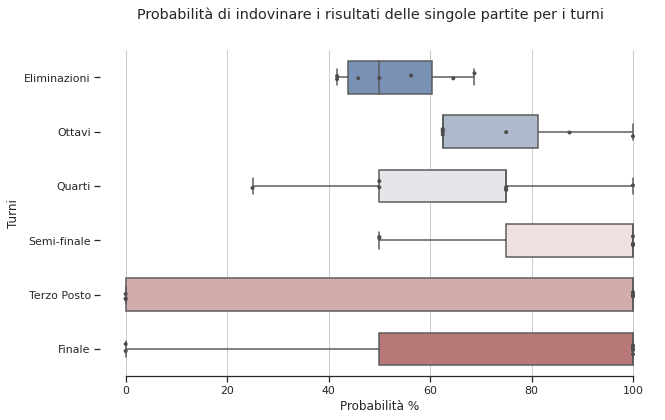

In [22]:
printPlot(dataForMatches, "Probabilità di indovinare i risultati delle singole partite per i turni")

Di segutio possiamo trovare diverse funzioni di ausilio alla predizione dei mondiali

In [23]:
def indexTeams(teams, numTeamMatches):
  reference = {}
  counter = 0

  for key,value in numTeamMatches.items():
    for i in range(value):
      reference[teams[counter]] = str(i+1) + key
      counter += 1

  return reference

def inverseIndexTeam(teams, numTeamMatches):
  counter = 0
  reference = {}

  for key, value in numTeamMatches.items():
    for i in range(value):
      reference[str(i+1)+key] = teams[counter]
      counter += 1

  return reference

def buildMatches(map, numTeamMatches, teams):
  reference = inverseIndexTeam(teams, numTeamMatches)
  teams = []

  for i in range(0, len(map), 2):
    teams.append(reference[map[i]])
    teams.append(reference[map[i+1]])

  return teams

def getRealWinnerTeam(teams):
  winner = []

  for row in teams:   
    if row['HomeTeamGoals'] > row['AwayTeamGoals'] or row['HomeTeamName'] in row['WinConditions']:
      winner.append(row['HomeTeamName'])
    else:
      winner.append(row['AwayTeamName'])

  return winner

def generateGroupStages(groupStage):
  #Esiste un numero arbitrario di gruppi per i mondiali
  groupDivision = {}

  #Ordino per Stage
  groupOrdered = pd.DataFrame(groupStage)
  groupOrdered = groupOrdered.sort_values(by = ['Stage', 'Datetime']).reset_index()

  for index,match in groupOrdered.iterrows():
    if match['Stage'] not in groupDivision.keys():
      groupDivision[match['Stage']] = []
    groupDivision[match['Stage']].append(match)

  return groupDivision

def initializeTeamResult(df,team):
  if len(df.query("team == @team")) == 0:  
    df = df.append({'team': team, 'points': 0,'probability': 1}, ignore_index = True)

  return df;

def updateRealResult(df,row):
  homeTeam = row['HomeTeamName']
  awayTeam = row['AwayTeamName']
  homeGoal = row['HomeTeamGoals']
  awayGoal = row['AwayTeamGoals']

  if len(df.query("team == @homeTeam")) == 0:
    df = df.append({'team': homeTeam, 'points': 0, 'goalScored': 0, 'goalConceded': 0}, ignore_index = True)

  if len(df.query("team == @awayTeam")) == 0:
    df = df.append({'team': awayTeam, 'points': 0, 'goalScored': 0, 'goalConceded': 0}, ignore_index = True)

  df.loc[df.team==homeTeam,'points'] += 3 if homeGoal > awayGoal or homeTeam in row['WinConditions'] else 1 if homeGoal==awayGoal else 0
  df.loc[df.team==awayTeam,'points'] += 3 if homeGoal < awayGoal or awayTeam in row['WinConditions'] else 1 if homeGoal==awayGoal else 0
  df.loc[df.team==homeTeam,'goalScored'] += homeGoal
  df.loc[df.team==homeTeam,'goalConceded'] -= awayGoal
  df.loc[df.team==awayTeam,'goalScored'] += awayGoal
  df.loc[df.team==awayTeam,'goalConceded'] -= homeGoal
  
  #goalConceded è negativo, quindi va sommato a goalScored
  df.loc[df.team==homeTeam,'diffScore'] = df.loc[df.team==homeTeam,'goalScored'] + df.loc[df.team==homeTeam,'goalConceded']
  df.loc[df.team==awayTeam,'diffScore'] = df.loc[df.team==awayTeam,'goalScored'] + df.loc[df.team==awayTeam,'goalConceded']
  return df

Questa funzione calcola per le eliminazioni quante sono le squadre che escono per ogni Gruppo. Nei casi di pareggio, tenta al meglio di ottimizzare il risultato attraverso la probabilità condizionata che la squadra possa aver vinto tutti i suoi match

In [24]:
def gironeEliminazione(fifaRanking, assigment,nextRound):  
  ottaviPanda = pd.DataFrame(nextRound)
  risultatiReali = []
  predizioneSquadre = []
  numTeamForGirone = {}
  listOfData = []
  indexGirone = 0

  #calcolo dei risultati dei gironi
  for gruppo in assigment.keys():      
    gironeResult = pd.DataFrame(columns=['team','points','probability']);
    realResult = pd.DataFrame(columns=['team','points','goalScored','goalConceded','diffScore'])
   
    girone = assigment[gruppo]

    for game in girone:
      gironeResult =initializeTeamResult(gironeResult, game['HomeTeamName'])
      gironeResult = initializeTeamResult(gironeResult, game['AwayTeamName'])
      realResult = updateRealResult(realResult, game)
    
    for teamsCombination in combinations(gironeResult['team'], 2):
      row = getNormalizedRow(fifaRanking, teamsCombination[0],teamsCombination[1])
      listOfData.append(row)
      
    pred_set, backup_pred_set = dataPrepare(listOfData,scaler,final.columns)

    predictions = logreg.predict(pred_set)

    for i in range(len(predictions)):
      favoriteTeam = backup_pred_set.iloc[i, 0]
      sfavoriteTeam = backup_pred_set.iloc[i, 1]
      if predictions[i] == 2:
        gironeResult.loc[gironeResult.team==favoriteTeam,'points'] += 3
      elif predictions[i] == 1:
        gironeResult.loc[gironeResult.team==favoriteTeam,'points'] += 1
        gironeResult.loc[gironeResult.team==sfavoriteTeam,'points'] += 1
      elif predictions[i] == 0:
        gironeResult.loc[gironeResult.team==sfavoriteTeam,'points'] += 3

      gironeResult.loc[gironeResult.team==favoriteTeam,'probability'] *= logreg.predict_proba(pred_set)[i][2]
      gironeResult.loc[gironeResult.team==sfavoriteTeam,'probability'] *= logreg.predict_proba(pred_set)[i][0]

    gironeResult.sort_values(by=['points','probability'],ascending=False,inplace=True,ignore_index=True)
    realResult.sort_values(by=['points','diffScore','goalScored'],ascending=False,inplace=True,ignore_index=True)
   
    #Per risolvere i problemi del numero di squadre passate, vado a guardare quante squadre trovo 
    #nel turno successivo. Eventuali problemi di pareggio possono essere corretti attraverso l'order qui sopra
    #nel caso sia intervenuto il sorteggio o altri dati esterni, sarà necessario fare affidamento ad un'altro ordinamento
    teamFounds = 0
    
    for index,row in realResult.iterrows():
      team = row['team']
      if len(ottaviPanda.loc[ottaviPanda['HomeTeamName'] == team])>0 or  len(ottaviPanda.loc[ottaviPanda['AwayTeamName'] == team])>0:
        teamFounds+=1
        risultatiReali.append(team)

    numTeamForGirone[chr(65+indexGirone)] = teamFounds

    for i in range(teamFounds):
      predizioneSquadre.append(gironeResult.team[i])

    indexGirone+=1

  return risultatiReali,predizioneSquadre,numTeamForGirone


Questa è la funzione più complessa che assegna come si devono svolgere correttamente i matches. Prende in input 3 dati reali, le coppie/triplette di squadre che escono dalle eliminazioni, verifica come si devono scontrare nei quarti e nella semi finale

In [25]:
def buildMapMatches(teamPosition,numTeamMatches,matchingData,quarter,semiFinals):
    reference = indexTeams(teamPosition,numTeamMatches)
    quarter = pd.DataFrame(quarter)
    semiFinals = pd.DataFrame(semiFinals)
    #Il problema con gli Ottavi, è che non sono ordinati quindi devo provvedere a riordinarli qui
    fourGroup = []
    teamToSearch = {} #Team -> Index to aggregate
    index = 0

    for row in matchingData:
      homeTeam = row['HomeTeamName']
      awayTeam = row['AwayTeamName']

      #Trovato una coppia, va capito in quale dei 4 gruppi dovrà essere inserito      
      #Cerco se ho già trovato una squadra vincente
      if homeTeam in teamToSearch:        
        fourGroup[teamToSearch[homeTeam]].append(homeTeam) 
        fourGroup[teamToSearch[homeTeam]].append(awayTeam)     
      elif awayTeam in teamToSearch:        
        fourGroup[teamToSearch[awayTeam]].append(homeTeam) 
        fourGroup[teamToSearch[awayTeam]].append(awayTeam)
      else:        
        #creo una nuova combinazione
        fourGroup.append([homeTeam,awayTeam])
        #Questa è una delle due squadre che dovrà poi andare alla semifinale
        nextMatch = quarter.query("HomeTeamName==@homeTeam or AwayTeamName==@homeTeam or AwayTeamName==@awayTeam or HomeTeamName==@awayTeam").iloc[0]
        
        #non so ancora chi sarà la squadra vincitrice
        if nextMatch['HomeTeamName']==homeTeam or nextMatch['HomeTeamName']==awayTeam:         
          #significa che AwayTeam sarà la squadra con cui mi dovrò confrontare al prossimo turno
          teamToSearch[nextMatch['AwayTeamName']] = index
        else:          
          teamToSearch[nextMatch['HomeTeamName']] = index
        index += 1

    teamToSearch = {} #Team -> Index to aggregate
    index = 0
    twoGroup = []
    
    #Ora ho 4 gruppi per la semi finale, devo decidere in che ordine questi 4 gruppi dovranno scontrarsi tra di loro
    for group in fourGroup:
      #cerco tra le 4 squadre, quale è passata anche al turno della semifinale      
      for team in group:
        #se ho già trovato la squadra, conosco l'indice dove inserire l'intero gruppo
        if team in teamToSearch:
          twoGroup[teamToSearch[team]] = twoGroup[teamToSearch[team]] + group
          break
        else:
          #non ho ancora trovato la squadra, verifico se questa è una squadra che andrà in Semifinale e nel caso inizializzo
          nextMatch = semiFinals.query("HomeTeamName==@team or AwayTeamName==@team")
          if len(nextMatch)>0: #ho trovato una squadra che andrà in semi finale
            nextMatch = nextMatch.iloc[0]
            twoGroup.append(group)            
            if nextMatch['HomeTeamName']==team:
              teamToSearch[nextMatch['AwayTeamName']] = index
            else:
              teamToSearch[nextMatch['HomeTeamName']] = index
            index +=1
            break
    #Finalmente ho le sequenze ordinate
    teamSequence = twoGroup[0]+twoGroup[1] #l'ordine non è importante, in quanto si dovranno scontrare nella finale 1 vs 1
    teamCombination = []
    for i in range(0,len(teamSequence),2):
      homeIndex = reference[teamSequence[i]]
      awayIndex = reference[teamSequence[i+1]]
      teamCombination.append(homeIndex)
      teamCombination.append(awayIndex)    
    return teamCombination

Attraverso questa funzione simuliamo l'intero svolgimento del mondiale.  L'algoritmo calcolerà attraverso i dati di verifica quali sono le squadre che si devono scontrare ad ogni turno (Es Squadra 1A vs 2C). Inoltre creerà la corretta suddivisione dei rami per effettuare gli scontri.
In alcuni casi, come nel 1994, è stato necessario utilizzare dati manuali per effettuare le correzioni.

In [26]:
def analisiMondiale(df, year, manualFix = None):
  aiResult = {}
  worldCupDate = datetime.strptime(str(year)+'-10-01', '%Y-%m-%d')
  fifaRankingBeforeDate = fifaWorldRanking.query('rank_date <= @worldCupDate')
  sequence = ['Round','Quarter']
  stages = divisionePerStage(df,year)
  #Il girone "Group" prende le 2 squadre che hanno ottenuto più punti
  #quindi necessita di una funzione particolare
  group = generateGroupStages(stages['Group'])
  
  squadrePassate, predizioneSquadre,numTeamPerMatches = gironeEliminazione(fifaRankingBeforeDate,group,stages['Round']) 
  squadrePassate = squadrePassate if manualFix is None else manualFix
    
  precision = calculatePrecisionWithPosition(squadrePassate,predizioneSquadre,False) 
  aiResult['Group'] = precision
  mapGroup = buildMapMatches(squadrePassate,numTeamPerMatches,stages['Round'],stages['Quarter'],stages['Semi-finals'])

  predizioneSquadre = buildMatches(mapGroup,numTeamPerMatches,predizioneSquadre)

  #Da questo punto in poi, i dati possiedono tutti la stessa logica, quindi la loro analisi è semplificata fino ad arrivare alla semi-finale
  for key in sequence:  
    predizioneSquadre = round_result(predizioneSquadre,fifaRankingBeforeDate,possibleDraw=False)
    squadrePassate = getRealWinnerTeam(stages[key])
    precision = calculatePrecisionWithoutPosition(squadrePassate,predizioneSquadre,False)
    aiResult[key] =  precision
    
  #Mi Calcolo a parte come arrivano in finale e chi si scontrerà per il terzo posto
  squadrePassate = getRealWinnerTeam(stages['Semi-finals'])
  #primo scontro
  firstMatch = round_result([predizioneSquadre[0],predizioneSquadre[1]],fifaRankingBeforeDate,possibleDraw=False)
  #secondo scontro
  secondMatch = round_result([predizioneSquadre[2],predizioneSquadre[3]],fifaRankingBeforeDate,possibleDraw=False)
  thirdPlace = [
    predizioneSquadre[1] if predizioneSquadre[0] in firstMatch else predizioneSquadre[0],
    predizioneSquadre[3] if predizioneSquadre[2] in secondMatch else predizioneSquadre[2],
  ]
  predizioneFinale = firstMatch+secondMatch
  precision = calculatePrecisionWithoutPosition(squadrePassate,predizioneFinale,False)
  aiResult['Semi-finals'] = precision  

  #Ora mi scontro per il terzo posto
  thirdPlaceWinner = round_result(thirdPlace,fifaRankingBeforeDate,possibleDraw=False)
  squadrePassate = getRealWinnerTeam(stages['Third place'])
  precision = calculatePrecisionWithoutPosition(squadrePassate,thirdPlaceWinner,False)
  aiResult['Third place'] = precision  

  #Ora mi scontro per la finale
  winner = round_result(predizioneFinale,fifaRankingBeforeDate,possibleDraw=False)
  squadrePassate = getRealWinnerTeam(stages['Final'])
  precision = calculatePrecisionWithoutPosition(squadrePassate,winner,False)
  aiResult['Final'] =precision  
  return aiResult

Purtroppo a causa di alcuni pareggi durante le eliminazioni, per i quali vengono calcolati i risultati in modo randomico o tramite dinamiche delle quali non disponiamo nel dataset, è stato necessario creare un dizionario di correzioni, per quegli anni problematici. Questo permette di avere un risultato più preciso per la nostra analisi

In [27]:
manualFix = {
    1994: ['Romania','Switzerland','United States',
             'Brazil','Sweden',
             'Germany','Spain',
             'Nigeria','Bulgaria','Argentina',
             'Mexico','Republic of Ireland','Italy',
             'Netherlands','Saudi Arabia','Belgium']
}

Con il seguente codice possiamo notare le varie percentuali sull'intera analisi dei mondiale

In [28]:
dataForMatches = []
for year in range(1994,2019,4):
  results = analisiMondiale(worldCupMatches,year,manualFix[year] if year in manualFix else None)
  print("Risultati per "+str(year))
  print(results)
  for key in results.keys():
    dataForMatches.append(
        {'year': year,
         'round': keyForPlot(key),
         'value': results[key]}
    )

Risultati per 1994
{'Group': 46.875, 'Round': 75.0, 'Quarter': 50.0, 'Semi-finals': 100.0, 'Third place': 0.0, 'Final': 100.0}
Risultati per 1998
{'Group': 81.25, 'Round': 62.5, 'Quarter': 50.0, 'Semi-finals': 50.0, 'Third place': 0.0, 'Final': 0.0}
Risultati per 2002
{'Group': 59.375, 'Round': 50.0, 'Quarter': 50.0, 'Semi-finals': 50.0, 'Third place': 0.0, 'Final': 100.0}
Risultati per 2006
{'Group': 68.75, 'Round': 87.5, 'Quarter': 25.0, 'Semi-finals': 50.0, 'Third place': 0.0, 'Final': 0.0}
Risultati per 2010
{'Group': 59.375, 'Round': 75.0, 'Quarter': 50.0, 'Semi-finals': 50.0, 'Third place': 0.0, 'Final': 100.0}
Risultati per 2014
{'Group': 50.0, 'Round': 50.0, 'Quarter': 75.0, 'Semi-finals': 50.0, 'Third place': 0.0, 'Final': 0.0}
Risultati per 2018
{'Group': 68.75, 'Round': 50.0, 'Quarter': 0.0, 'Semi-finals': 0.0, 'Third place': 0.0, 'Final': 0.0}


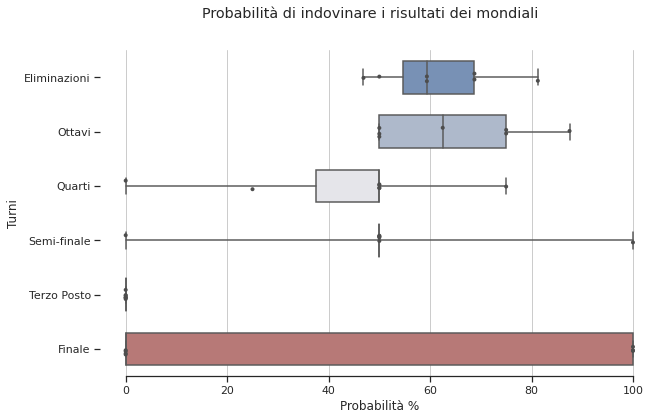

In [29]:
dataForMatches = pd.DataFrame(dataForMatches)
dataForMatches.head()
printPlot(dataForMatches,"Probabilità di indovinare i risultati dei mondiali")

**Prendendo in analisi più da vicino il mondiale del 2018, questa è la nostra predizione**

In questa analisi non teniamo conto della formazione delle squadre, dei luoghi dove vengono tenute le partite, ecc.

L'analisi tiene conto solamente di quella che è la storia delle squadre.

In [30]:
squadre_passate = []
#La data del 2018-12-31 è una scelta arbitraria e non legata alle reali date delle partite
worldCupDate = datetime.strptime('2018-12-31', '%Y-%m-%d')
fifaRankingBeforeDate = fifaWorldRanking.query('rank_date <= @worldCupDate')

#calcolo dei risultati dei gironi
for girone in fifaAssignment:
  gironeResult = []

  for team in girone:
      gironeResult.append({'team':team, 'points':0,'probability':1})
      
  gironeResult = pd.DataFrame(gironeResult)
  listOfData = [] 
  
  for teamsCombination in combinations(girone, 2):
    row = getNormalizedRow(fifaRankingBeforeDate, teamsCombination[0],teamsCombination[1])
    listOfData.append(row)

  pred_set, backup_pred_set = dataPrepare(listOfData,scaler,final.columns)
  predictions = logreg.predict(pred_set)  

  for i in range(len(predictions)):
    favoriteTeam = backup_pred_set.iloc[i, 0]
    sfavoriteTeam = backup_pred_set.iloc[i, 1]

    if predictions[i] == 2:
      gironeResult.loc[gironeResult.team==favoriteTeam,'points'] += 3
    elif predictions[i] == 1:
      gironeResult.loc[gironeResult.team==favoriteTeam,'points']  += 1
      gironeResult.loc[gironeResult.team==sfavoriteTeam,'points'] += 1
    elif predictions[i] == 0:
      gironeResult.loc[gironeResult.team==sfavoriteTeam,'points'] += 3

    gironeResult.loc[gironeResult.team==favoriteTeam,'probability']  *= logreg.predict_proba(pred_set)[i][2]
    gironeResult.loc[gironeResult.team==sfavoriteTeam,'probability'] *= logreg.predict_proba(pred_set)[i][0]

  gironeResult.sort_values(by=['points','probability'],ascending=False,inplace=True,ignore_index=True)
  squadre_passate.append(gironeResult.team[0])
  squadre_passate.append(gironeResult.team[1])


Calcola l'avanzamento della competizione dagli ottavi fino ad arrivare al vincitore del mondiale

In [31]:
ottaviForCheck = ['Uruguay', 'Russia', 'Spain', 'Portugal', 'France', 'Denmark', 'Croatia','Argentina', 'Brazil', 'Switzerland',  'Sweden',
              'Mexico','Belgium', 'England',  'Colombia', 'Japan']

print(squadre_passate)
calculatePrecisionWithPosition(ottaviForCheck,squadre_passate)
firstHalf = []
secondHalf = []

for pos in range(0, len(squadre_passate)-1, 4):
  firstHalf.append(squadre_passate[pos])
  firstHalf.append(squadre_passate[pos+3])
  secondHalf.append(squadre_passate[pos+1])
  secondHalf.append(squadre_passate[pos+2])

squadre = firstHalf+secondHalf
sequenceToCheck = [realQuarti,realSemifinale,realFinale,realVincitore]

i = 0
while len(squadre) > 1:
  squadre = round_result(squadre,fifaRankingBeforeDate)
  print(squadre)
  calculatePrecisionWithoutPosition(sequenceToCheck[i],squadre)
  i+=1
print("Ha vinto il mondiale: ")
print(squadre)

['Uruguay', 'Russia', 'Spain', 'Portugal', 'France', 'Peru', 'Croatia', 'Argentina', 'Brazil', 'Switzerland', 'Germany', 'Sweden', 'England', 'Belgium', 'Poland', 'Colombia']
Risultato corretto al 68.75%
['Portugal', 'Argentina', 'Brazil', 'England', 'Spain', 'Croatia', 'Germany', 'Belgium']
Risultato corretto al 50.0%
['Portugal', 'Brazil', 'Spain', 'Germany']
Risultato corretto al 0.0%
['Brazil', 'Germany']
Risultato corretto al 0.0%
['Brazil']
Risultato corretto al 0.0%
Ha vinto il mondiale: 
['Brazil']


Nonostante la predizione sia sbagliata, tenendo conto che come in tutti i giochi esistono moltissime variabili che possono andare a condizionare l'intero esito, riteniamo comunque buono il risultato poichè sulla carta il Brasile risultava la favorita.

A prova di ciò si possono vedere le quote (in termini di scommesse) del mondiale del 2018:

https://sport.sky.it/pronostici-scommesse/2018/06/11/quote-vincente-mondiali